<a href="https://colab.research.google.com/github/hamish-haggerty/AI-hacking/blob/master/SSL/cancer_ensemble_bt_sup.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# cancer_ensemble

> Purpose of this notebook is to get ensembling results (final) on validation data, and to store the models so that we can also get results on the test set. 

The hope (based on preliminary experiments) is that ensembling "between" models is better than ensembling "within" models.

These are for initial weights supervised and self-supervised. Hence, there is no additional pretraining done. 

In [1]:
#| default_exp cancer_validation_ensemble

Setup: Surely there is a way to get rid of having to put this cell everywhere. hmmm.

Or we can just copy paste / delete this in and out when needed. Either way, getting close to a decent workable workflow.

In [2]:
#| hide
import os
from google.colab import drive

def colab_is_true():

    try: 
        from google.colab import drive

        return True 
    except ModuleNotFoundError:
        return False

def setup_colab():

    drive.mount('/content/drive',force_remount=True)
    #os.system('unzip -q "/content/drive/My Drive/archive (1).zip"')
    os.system('git clone https://github.com/hamish-haggerty/cancer-proj.git')

    os.chdir('cancer-proj')
    
    os.system('pip install .')
    os.system('pip install -qU nbdev')
    os.system('nbdev_install_quarto')

    os.system('unzip -q "/content/drive/My Drive/archive (1).zip"') #does this work?

if __name__ == "__main__":
    on_colab = colab_is_true()
    if on_colab:
        setup_colab()

Mounted at /content/drive


In [3]:
#| hide
from nbdev.showdoc import *

In [4]:
#| export
from fastai.vision.all import *
from base_rbt.all import *
from cancer_proj.cancer_dataloading import *
from cancer_proj.cancer_metrics import *
from cancer_proj.cancer_maintrain import *

## Load the data

In [5]:
#| hide

#Since we have cloned repository and cd'd into it (and the data itself is not stored in the
#repo) we need cd out of it, get the data, then cd back into the repo `cancer-proj`.
#This is a bit annoying, can maybe remove this later
if on_colab:
    #os.chdir('..') #assumes we are currently in cancer-proj directory
    train_dir = colab_train_dir
    test_dir = colab_test_dir
else:
    train_dir = local_train_dir
    test_dir = local_test_dir

#define general hps
device ='cuda' if torch.cuda.is_available() else 'cpu'
#bs=256
#bs=698
bs=256
bs_tune=256
size=128
bs_val=174

#get the data dictionary
data_dict = get_fnames_dls_dict(train_dir=train_dir,test_dir=test_dir,
                    device=device,bs_val=bs_val,bs=bs,bs_tune=bs_tune,size=size,n_in=3)

#get the dataloaders
dls_train,dls_tune,dls_valid = data_dict['dls_train'],data_dict['dls_tune'],data_dict['dls_valid']
x,y = data_dict['x'],data_dict['y']
xval,yval = data_dict['xval'],data_dict['yval']
xtune,ytune = data_dict['xtune'],data_dict['ytune']
vocab = data_dict['vocab']

#If we want to write some tests (make sure the data is same every time etc):
fnames,fnames_train,fnames_tune,fnames_valid,fnames_test = data_dict['fnames'],data_dict['fnames_train'],data_dict['fnames_tune'],data_dict['fnames_valid'],data_dict['fnames_test']

test_eq(x.shape,xtune.shape)

# if on_colab:
#     os.chdir('cancer-proj')

## Load aug pipelines here

In [6]:
#| hide

aug_dict = create_aug_pipelines(size=size,device=device,Augs=BYOL_Augs,TUNE_Augs=TUNE_Augs,Val_Augs=Val_Augs)
aug_pipelines = aug_dict['aug_pipelines']
aug_pipelines_tune = aug_dict['aug_pipelines_tune']
aug_pipelines_test = aug_dict['aug_pipelines_test'] 

## Debugging

In [12]:
for _ in range(3):
    main = main_train(dls_train=dls_train,dls_tune=dls_tune,dls_valid=dls_valid, xval=xval, yval=yval,
        aug_pipelines=aug_pipelines, aug_pipelines_tune=aug_pipelines_tune, aug_pipelines_test=aug_pipelines_test, 
        initial_weights='supervised_pretrain',pretrain=False,
        num_epochs='na',numfit=50,freeze_num_epochs='na',freeze_numfit=3,
        print_report=True,
                )

    metrics = main.fine_tune()

print('We expect at least some ~ 0.65 and above...')
print('default fit_type is linear_fine_tune')

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,time
0,2.233794,None,00:13
1,2.228899,None,00:06
2,2.201622,None,00:06


/usr/local/lib/python3.8/dist-packages/fastprogress/fastprogress.py:73: UserWarning: Your generator is empty.
  warn("Your generator is empty.")


epoch,train_loss,valid_loss,time
0,2.052356,None,00:06
1,1.974160,None,00:06
2,1.892167,None,00:06
3,1.813794,None,00:06
4,1.723847,None,00:06
5,1.625943,None,00:06
6,1.521340,None,00:06
7,1.408073,None,00:06
8,1.301348,None,00:05
9,1.200386,None,00:06


                            precision    recall  f1-score   support

         actinic keratosis       0.57      0.65      0.60        20
      basal cell carcinoma       0.64      0.70      0.67        20
            dermatofibroma       0.74      0.89      0.81        19
                  melanoma       0.39      0.35      0.37        20
                     nevus       0.65      0.75      0.70        20
pigmented benign keratosis       0.71      0.50      0.59        20
      seborrheic keratosis       0.36      0.33      0.34        15
   squamous cell carcinoma       0.65      0.55      0.59        20
           vascular lesion       0.90      0.90      0.90        20

                  accuracy                           0.63       174
                 macro avg       0.62      0.63      0.62       174
              weighted avg       0.63      0.63      0.63       174



epoch,train_loss,valid_loss,time
0,2.214585,None,00:07
1,2.199463,None,00:06
2,2.175637,None,00:06


/usr/local/lib/python3.8/dist-packages/fastprogress/fastprogress.py:73: UserWarning: Your generator is empty.
  warn("Your generator is empty.")


epoch,train_loss,valid_loss,time
0,2.035071,None,00:06
1,1.954042,None,00:06
2,1.862821,None,00:07
3,1.766149,None,00:06
4,1.675497,None,00:06
5,1.580050,None,00:06
6,1.482011,None,00:06
7,1.375450,None,00:06
8,1.273370,None,00:06
9,1.178789,None,00:06


                            precision    recall  f1-score   support

         actinic keratosis       0.52      0.70      0.60        20
      basal cell carcinoma       0.82      0.70      0.76        20
            dermatofibroma       0.77      0.89      0.83        19
                  melanoma       0.45      0.45      0.45        20
                     nevus       0.67      0.60      0.63        20
pigmented benign keratosis       0.67      0.60      0.63        20
      seborrheic keratosis       0.31      0.27      0.29        15
   squamous cell carcinoma       0.65      0.55      0.59        20
           vascular lesion       0.91      1.00      0.95        20

                  accuracy                           0.65       174
                 macro avg       0.64      0.64      0.64       174
              weighted avg       0.65      0.65      0.65       174



epoch,train_loss,valid_loss,time
0,2.192938,None,00:06
1,2.180194,None,00:06
2,2.158639,None,00:06


/usr/local/lib/python3.8/dist-packages/fastprogress/fastprogress.py:73: UserWarning: Your generator is empty.
  warn("Your generator is empty.")


epoch,train_loss,valid_loss,time
0,2.008365,None,00:06
1,1.926723,None,00:06
2,1.844571,None,00:06
3,1.756373,None,00:06
4,1.659321,None,00:07
5,1.560656,None,00:06
6,1.457651,None,00:06
7,1.356092,None,00:06
8,1.254079,None,00:06
9,1.155026,None,00:06


                            precision    recall  f1-score   support

         actinic keratosis       0.55      0.60      0.57        20
      basal cell carcinoma       0.65      0.55      0.59        20
            dermatofibroma       0.74      0.89      0.81        19
                  melanoma       0.30      0.30      0.30        20
                     nevus       0.62      0.40      0.48        20
pigmented benign keratosis       0.76      0.65      0.70        20
      seborrheic keratosis       0.39      0.60      0.47        15
   squamous cell carcinoma       0.62      0.50      0.56        20
           vascular lesion       0.87      1.00      0.93        20

                  accuracy                           0.61       174
                 macro avg       0.61      0.61      0.60       174
              weighted avg       0.62      0.61      0.61       174

We expect at least some ~ 0.65 and above...
default fit_type is linear_fine_tune


## Let's 

## Ok, great. Seems to work.

# Now let's just run 

## Optionally, display:

In [ ]:
#| hide
#show_bt_batch(dls=dls_train,aug=aug_pipelines,n_in=3)

In [ ]:
#| hide

show_linear_batch(dls=dls_tune,n_in=3,aug=aug_pipelines_tune,n=2,print_augs=True)

In [ ]:
#| export

@patch
def lf(self:BarlowTwins, pred,*yb): return lf_bt(pred,I=self.I,lmb=self.lmb)

## Test: make sure that it freezes the appropriate part of model:

Make sure resnet frozen, linear head unfrozen:

In [ ]:
LM??

In [ ]:
bt_model,encoder = create_model(which_model='bt_pretrain',ps=8192,device=device)
model = LM(encoder)
test_eq(len(my_splitter(model)),2)
test_eq(len(my_splitter_bt(bt_model)),2)

learn = Learner(dls_tune,model,splitter=my_splitter,cbs = [LinearBt(aug_pipelines=aug_pipelines_tune,n_in=3)],wd=0.0)
learn.freeze()
print('body should be frozen, (sans batchnorm) linear head unfrozen')
learn.summary()

## We need to edit `main` so that

In [ ]:
@patch
@delegates(Learner.fit_one_cycle)
def linear_fine_tune(self:Learner, epochs, base_lr=2e-3, freeze_epochs=1, lr_mult=100,
              pct_start=0.3, div=5.0, **kwargs):
    "Extremely minor change to fine_tune, but seems to work better"
    
    self.freeze()
    self.fit_one_cycle(freeze_epochs, slice(base_lr), pct_start=0.99, **kwargs)
    base_lr /= 2
    self.unfreeze()
    #self.fit_one_cycle(epochs, slice(base_lr/lr_mult, base_lr), pct_start=pct_start, div=div, **kwargs)
    self.fit_one_cycle(epochs, slice(base_lr, base_lr), pct_start=pct_start, div=div, **kwargs)

In [ ]:
@patch_to(main_train)
def fit(learn,fit_type,epochs,freeze_epochs,initial_weights,pretrain):
    """We can patch in a modification, e.g. if we want subtype of fine_tune:supervised_pretrain to be different
    to fine_tune:bt_pretrain"""

    if fit_type == 'encoder_fine_tune': #i.e. barlow twins
        assert False

        #learn.encoder_fine_tune(epochs,freeze_epochs=freeze_epochs)
        lr_max=0.0030199517495930195
        print(f'lr_max={lr_max}')
        learn.fit_one_cycle(epochs,lr_max= lr_max)

    elif fit_type == 'fine_tune':

        if pretrain == False:
            assert False
            print('pretrain was False, and about to fit_one_cycle')
            learn.fit_one_cycle(epochs,lr_max=0.00027542) 

        elif pretrain == True:
            print('pretrain was True, and about to linear_fine_tune')
            learn.linear_fine_tune(epochs,freeze_epochs=freeze_epochs) #This gave very similar performance, when pretrain=False (see above)

        #learn.no_freeze_linear_fine_tune(epochs,freeze_epochs=freeze_epochs) 

    else: raise Exception('Fit policy not of expected form')


@patch
def fine_tune(self:main_train):
    "fine tune in supervised fashion, according to tune_fit_policy, and get metrics"


    #encoder = pickle.loads(pickle.dumps(self.encoder)) #We might want to pretrain once and fine tune several times (varying e.g. tune augs)

    try: 
        encoder = self.encoder
    
    except AttributeError:
        _,self.encoder = create_model(which_model=self.initial_weights,ps=self.ps,device=self.device)

    model = LM(self.encoder)
    learn = Learner(self.dls_tune,model,splitter=my_splitter,cbs = [LinearBt(aug_pipelines=self.aug_pipelines_tune,n_in=self.n_in)],wd=0.0)

    #debugging
    #learn = Learner(self.dls_tune,model,cbs = [LinearBt(aug_pipelines=self.aug_pipelines_tune,n_in=self.n_in)],wd=0.0)

    main_train.fit(learn,fit_type='fine_tune',
                    epochs=self.numfit,freeze_epochs=self.freeze_numfit,
                    initial_weights=self.initial_weights,
                    pretrain=self.pretrain
                    ) #fine tuning (don't confuse this with fit policy!)
    scores,preds, acc = predict_model(self.xval,self.yval,model=model,aug_pipelines_test=self.aug_pipelines_test,numavg=3)
    #metrics dict will have f1 score, auc etc etc
    metrics = classification_report_wrapper(preds, self.yval, self.vocab, print_report=self.print_report)
    auc_dict = plot_roc(self.yval,preds,self.vocab,print_plot=self.print_plot)
    metrics['acc'],metrics['auc_dict'],metrics['scores'],metrics['preds'],metrics['xval'],metrics['yval'] = acc,auc_dict,scores,preds,self.xval,self.yval

    #torch.save(model.state_dict(), self.tuned_model_path)
    return metrics #


@patch
def train_encoder(self:main_train):
    "create encoder and (optionally, if pretrain=True) train with BT algorithm, according to fit_policy"

    try: #get existing encoder and plonk on new projector
        encoder = self.encoder
        encoder.cpu()
        bt_model = create_barlow_twins_model(encoder, hidden_size=self.ps,projection_size=self.ps,nlayers=3)
        bt_model.cuda()

    except AttributeError: #otherwise, create
        bt_model,encoder = create_model(which_model=self.initial_weights,ps=self.ps,device=self.device)

    if self.pretrain: #train encoder according to fit policy

        #lmb=0.005 #this guy doesn't seem to work
        lmb=1/8192
        print(f'lmb={lmb}')
        learn = Learner(self.dls_train,bt_model,splitter=my_splitter_bt,cbs=[BarlowTwins(self.aug_pipelines,n_in=self.n_in,lmb=lmb,print_augs=False)])
        main_train.fit(learn,fit_type='encoder_fine_tune',
                        epochs=self.num_epochs,freeze_epochs=self.freeze_num_epochs,
                        initial_weights=self.initial_weights,
                        pretrain=self.pretrain
                        )
        
    self.encoder = bt_model.encoder

## Experiment 1: using `linear_fine_tune`, for both kinds of initial weights (sup and bt)

First, just look at with freeze_epochs=1. The idea is this should be ~~ to using `fine_tune` without a splitter (i.e. no freezing)

In [25]:
@patch_to(main_train)
def fit(learn,fit_type,epochs,freeze_epochs,initial_weights,pretrain):
    """We can patch in a modification, e.g. if we want subtype of fine_tune:supervised_pretrain to be different
    to fine_tune:bt_pretrain"""

    if fit_type == 'encoder_fine_tune': #i.e. barlow twins
        assert False

        #learn.encoder_fine_tune(epochs,freeze_epochs=freeze_epochs)
        lr_max=0.0030199517495930195
        print(f'lr_max={lr_max}')
        learn.fit_one_cycle(epochs,lr_max= lr_max)

    elif fit_type == 'fine_tune':

        if pretrain == False:
            assert False
            print('pretrain was False, and about to fit_one_cycle')
            learn.fit_one_cycle(epochs,lr_max=0.00027542) 

        elif pretrain == True:
            print('pretrain was True, and about to linear_fine_tune')
            learn.linear_fine_tune(epochs,freeze_epochs=freeze_epochs) #This gave very similar performance, when pretrain=False (see above)

        #learn.no_freeze_linear_fine_tune(epochs,freeze_epochs=freeze_epochs) 

    else: raise Exception('Fit policy not of expected form')


@patch
def fine_tune(self:main_train):
    "fine tune in supervised fashion, according to tune_fit_policy, and get metrics"


    #encoder = pickle.loads(pickle.dumps(self.encoder)) #We might want to pretrain once and fine tune several times (varying e.g. tune augs)

    try: 
        encoder = self.encoder
    
    except AttributeError:
        _,self.encoder = create_model(which_model=self.initial_weights,ps=self.ps,device=self.device)

    model = LM(self.encoder)
    learn = Learner(self.dls_tune,model,splitter=my_splitter,cbs = [LinearBt(aug_pipelines=self.aug_pipelines_tune,n_in=self.n_in)],wd=0.0)

    #debugging
    #learn = Learner(self.dls_tune,model,cbs = [LinearBt(aug_pipelines=self.aug_pipelines_tune,n_in=self.n_in)],wd=0.0)

    main_train.fit(learn,fit_type='fine_tune',
                    epochs=self.numfit,freeze_epochs=self.freeze_numfit,
                    initial_weights=self.initial_weights,
                    pretrain=self.pretrain
                    ) #fine tuning (don't confuse this with fit policy!)
    scores,preds, acc = predict_model(self.xval,self.yval,model=model,aug_pipelines_test=self.aug_pipelines_test,numavg=3)
    #metrics dict will have f1 score, auc etc etc
    metrics = classification_report_wrapper(preds, self.yval, self.vocab, print_report=self.print_report)
    auc_dict = plot_roc(self.yval,preds,self.vocab,print_plot=self.print_plot)
    metrics['acc'],metrics['auc_dict'],metrics['scores'],metrics['preds'],metrics['xval'],metrics['yval'] = acc,auc_dict,scores,preds,self.xval,self.yval

    #torch.save(model.state_dict(), self.tuned_model_path)
    return metrics #


if __name__ == '__main__':
    from statistics import mean
    freeze_dict = {'supervised_pretrain':1,'bt_pretrain':1}
    acc_dict = {'supervised_pretrain':[],'bt_pretrain':[]}
    for _ in range(3):

        for initial_weights in ['supervised_pretrain','bt_pretrain']:

            main = main_train(dls_train=dls_train,dls_tune=dls_tune,dls_valid=dls_valid, xval=xval, yval=yval,
                aug_pipelines=aug_pipelines, aug_pipelines_tune=aug_pipelines_tune, aug_pipelines_test=aug_pipelines_test, 
                initial_weights=initial_weights,pretrain=True,
                num_epochs='na',numfit=50,freeze_num_epochs='na',freeze_numfit=freeze_dict[initial_weights],
                print_report=True,
                        )
            
            metrics = main.fine_tune()

            acc_dict[initial_weights].append(metrics['acc'])

    
    print(acc_dict)
    print(f"mean of 'supervised_pretrain' is: {mean(acc_dict['supervised_pretrain'])}")
    print(f"mean of 'bt_pretrain' is: {mean(acc_dict['bt_pretrain'])}")

    print('This is with freeze_epochs=1')
    print('')



pretrain was True, and about to linear_fine_tune


epoch,train_loss,valid_loss,time
0,2.188025,None,00:07


/usr/local/lib/python3.8/dist-packages/fastprogress/fastprogress.py:73: UserWarning: Your generator is empty.
  warn("Your generator is empty.")


epoch,train_loss,valid_loss,time
0,2.156549,None,00:07
1,2.097524,None,00:07
2,2.035245,None,00:06
3,1.963484,None,00:06
4,1.883679,None,00:07
5,1.799169,None,00:06
6,1.702381,None,00:06
7,1.594494,None,00:07
8,1.487975,None,00:06
9,1.386003,None,00:07


                            precision    recall  f1-score   support

         actinic keratosis       0.54      0.70      0.61        20
      basal cell carcinoma       0.65      0.65      0.65        20
            dermatofibroma       0.84      0.84      0.84        19
                  melanoma       0.39      0.55      0.46        20
                     nevus       0.62      0.50      0.56        20
pigmented benign keratosis       0.67      0.60      0.63        20
      seborrheic keratosis       0.20      0.13      0.16        15
   squamous cell carcinoma       0.73      0.55      0.63        20
           vascular lesion       0.91      1.00      0.95        20

                  accuracy                           0.63       174
                 macro avg       0.62      0.61      0.61       174
              weighted avg       0.63      0.63      0.62       174



Using cache found in /root/.cache/torch/hub/facebookresearch_barlowtwins_main
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


pretrain was True, and about to linear_fine_tune


epoch,train_loss,valid_loss,time
0,2.199760,None,00:06


/usr/local/lib/python3.8/dist-packages/fastprogress/fastprogress.py:73: UserWarning: Your generator is empty.
  warn("Your generator is empty.")


epoch,train_loss,valid_loss,time
0,2.187052,None,00:07
1,2.180578,None,00:06
2,2.176137,None,00:07
3,2.170896,None,00:06
4,2.165160,None,00:07
5,2.158672,None,00:06
6,2.151819,None,00:06
7,2.143790,None,00:06
8,2.134430,None,00:06
9,2.121031,None,00:07


                            precision    recall  f1-score   support

         actinic keratosis       0.70      0.70      0.70        20
      basal cell carcinoma       0.63      0.60      0.62        20
            dermatofibroma       0.71      0.89      0.79        19
                  melanoma       0.50      0.35      0.41        20
                     nevus       0.50      0.60      0.55        20
pigmented benign keratosis       0.57      0.60      0.59        20
      seborrheic keratosis       0.50      0.53      0.52        15
   squamous cell carcinoma       0.64      0.45      0.53        20
           vascular lesion       0.82      0.90      0.86        20

                  accuracy                           0.63       174
                 macro avg       0.62      0.63      0.62       174
              weighted avg       0.62      0.63      0.62       174

pretrain was True, and about to linear_fine_tune


epoch,train_loss,valid_loss,time
0,2.233118,None,00:06


/usr/local/lib/python3.8/dist-packages/fastprogress/fastprogress.py:73: UserWarning: Your generator is empty.
  warn("Your generator is empty.")


epoch,train_loss,valid_loss,time
0,2.177182,None,00:07
1,2.123430,None,00:06
2,2.061760,None,00:06
3,1.994766,None,00:06
4,1.919742,None,00:06
5,1.830541,None,00:06
6,1.740124,None,00:06
7,1.639211,None,00:06
8,1.537029,None,00:06
9,1.418150,None,00:07


                            precision    recall  f1-score   support

         actinic keratosis       0.64      0.70      0.67        20
      basal cell carcinoma       0.61      0.70      0.65        20
            dermatofibroma       0.68      0.79      0.73        19
                  melanoma       0.31      0.25      0.28        20
                     nevus       0.50      0.50      0.50        20
pigmented benign keratosis       0.61      0.55      0.58        20
      seborrheic keratosis       0.47      0.53      0.50        15
   squamous cell carcinoma       0.62      0.50      0.56        20
           vascular lesion       0.95      0.95      0.95        20

                  accuracy                           0.61       174
                 macro avg       0.60      0.61      0.60       174
              weighted avg       0.60      0.61      0.60       174



Using cache found in /root/.cache/torch/hub/facebookresearch_barlowtwins_main
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


pretrain was True, and about to linear_fine_tune


epoch,train_loss,valid_loss,time
0,2.199231,None,00:07


/usr/local/lib/python3.8/dist-packages/fastprogress/fastprogress.py:73: UserWarning: Your generator is empty.
  warn("Your generator is empty.")


epoch,train_loss,valid_loss,time
0,2.184664,None,00:06
1,2.180573,None,00:06
2,2.175617,None,00:07
3,2.170975,None,00:06
4,2.164683,None,00:07
5,2.158782,None,00:06
6,2.151367,None,00:07
7,2.143922,None,00:07
8,2.133973,None,00:07
9,2.122681,None,00:07


                            precision    recall  f1-score   support

         actinic keratosis       0.70      0.70      0.70        20
      basal cell carcinoma       0.65      0.65      0.65        20
            dermatofibroma       0.79      0.79      0.79        19
                  melanoma       0.50      0.45      0.47        20
                     nevus       0.61      0.70      0.65        20
pigmented benign keratosis       0.52      0.60      0.56        20
      seborrheic keratosis       0.58      0.47      0.52        15
   squamous cell carcinoma       0.69      0.55      0.61        20
           vascular lesion       0.83      0.95      0.88        20

                  accuracy                           0.66       174
                 macro avg       0.65      0.65      0.65       174
              weighted avg       0.65      0.66      0.65       174

pretrain was True, and about to linear_fine_tune


epoch,train_loss,valid_loss,time
0,2.206231,None,00:07


/usr/local/lib/python3.8/dist-packages/fastprogress/fastprogress.py:73: UserWarning: Your generator is empty.
  warn("Your generator is empty.")


epoch,train_loss,valid_loss,time
0,2.148135,None,00:07
1,2.102323,None,00:07
2,2.035204,None,00:06
3,1.967149,None,00:06
4,1.881834,None,00:06
5,1.797797,None,00:07
6,1.710041,None,00:07
7,1.612401,None,00:07
8,1.505088,None,00:06
9,1.396941,None,00:06


                            precision    recall  f1-score   support

         actinic keratosis       0.56      0.75      0.64        20
      basal cell carcinoma       0.75      0.45      0.56        20
            dermatofibroma       0.77      0.89      0.83        19
                  melanoma       0.33      0.35      0.34        20
                     nevus       0.52      0.55      0.54        20
pigmented benign keratosis       0.68      0.65      0.67        20
      seborrheic keratosis       0.31      0.27      0.29        15
   squamous cell carcinoma       0.73      0.55      0.63        20
           vascular lesion       0.83      1.00      0.91        20

                  accuracy                           0.61       174
                 macro avg       0.61      0.61      0.60       174
              weighted avg       0.62      0.61      0.61       174



Using cache found in /root/.cache/torch/hub/facebookresearch_barlowtwins_main
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


pretrain was True, and about to linear_fine_tune


epoch,train_loss,valid_loss,time
0,2.197761,None,00:07


/usr/local/lib/python3.8/dist-packages/fastprogress/fastprogress.py:73: UserWarning: Your generator is empty.
  warn("Your generator is empty.")


epoch,train_loss,valid_loss,time
0,2.183650,None,00:07
1,2.179555,None,00:07
2,2.173217,None,00:07
3,2.167891,None,00:07
4,2.162698,None,00:07
5,2.157215,None,00:07
6,2.150388,None,00:07
7,2.142072,None,00:07
8,2.132486,None,00:07
9,2.120263,None,00:07


                            precision    recall  f1-score   support

         actinic keratosis       0.64      0.70      0.67        20
      basal cell carcinoma       0.63      0.60      0.62        20
            dermatofibroma       0.84      0.84      0.84        19
                  melanoma       0.62      0.40      0.48        20
                     nevus       0.55      0.60      0.57        20
pigmented benign keratosis       0.48      0.65      0.55        20
      seborrheic keratosis       0.56      0.60      0.58        15
   squamous cell carcinoma       0.77      0.50      0.61        20
           vascular lesion       0.83      0.95      0.88        20

                  accuracy                           0.65       174
                 macro avg       0.66      0.65      0.64       174
              weighted avg       0.66      0.65      0.65       174

{'supervised_pretrain': [0.6264367699623108, 0.6091954112052917, 0.6149425506591797], 'bt_pretrain': [0.626436769

Experiment: Now `linear_fine_tune` but set freeze_epochs to 6

In [27]:
@patch_to(main_train)
def fit(learn,fit_type,epochs,freeze_epochs,initial_weights,pretrain):
    """We can patch in a modification, e.g. if we want subtype of fine_tune:supervised_pretrain to be different
    to fine_tune:bt_pretrain"""

    if fit_type == 'encoder_fine_tune': #i.e. barlow twins
        assert False

        #learn.encoder_fine_tune(epochs,freeze_epochs=freeze_epochs)
        lr_max=0.0030199517495930195
        print(f'lr_max={lr_max}')
        learn.fit_one_cycle(epochs,lr_max= lr_max)

    elif fit_type == 'fine_tune':

        if pretrain == False:
            assert False
            print('pretrain was False, and about to fit_one_cycle')
            learn.fit_one_cycle(epochs,lr_max=0.00027542) 

        elif pretrain == True:
            print('pretrain was True, and about to linear_fine_tune')
            learn.linear_fine_tune(epochs,freeze_epochs=freeze_epochs) #This gave very similar performance, when pretrain=False (see above)

        #learn.no_freeze_linear_fine_tune(epochs,freeze_epochs=freeze_epochs) 

    else: raise Exception('Fit policy not of expected form')


@patch
def fine_tune(self:main_train):
    "fine tune in supervised fashion, according to tune_fit_policy, and get metrics"


    #encoder = pickle.loads(pickle.dumps(self.encoder)) #We might want to pretrain once and fine tune several times (varying e.g. tune augs)

    try: 
        encoder = self.encoder
    
    except AttributeError:
        _,self.encoder = create_model(which_model=self.initial_weights,ps=self.ps,device=self.device)

    model = LM(self.encoder)
    learn = Learner(self.dls_tune,model,splitter=my_splitter,cbs = [LinearBt(aug_pipelines=self.aug_pipelines_tune,n_in=self.n_in)],wd=0.0)

    #debugging
    #learn = Learner(self.dls_tune,model,cbs = [LinearBt(aug_pipelines=self.aug_pipelines_tune,n_in=self.n_in)],wd=0.0)

    main_train.fit(learn,fit_type='fine_tune',
                    epochs=self.numfit,freeze_epochs=self.freeze_numfit,
                    initial_weights=self.initial_weights,
                    pretrain=self.pretrain
                    ) #fine tuning (don't confuse this with fit policy!)
    scores,preds, acc = predict_model(self.xval,self.yval,model=model,aug_pipelines_test=self.aug_pipelines_test,numavg=3)
    #metrics dict will have f1 score, auc etc etc
    metrics = classification_report_wrapper(preds, self.yval, self.vocab, print_report=self.print_report)
    auc_dict = plot_roc(self.yval,preds,self.vocab,print_plot=self.print_plot)
    metrics['acc'],metrics['auc_dict'],metrics['scores'],metrics['preds'],metrics['xval'],metrics['yval'] = acc,auc_dict,scores,preds,self.xval,self.yval

    #torch.save(model.state_dict(), self.tuned_model_path)
    return metrics #


if __name__ == '__main__':
    from statistics import mean
    freeze_dict = {'supervised_pretrain':6,'bt_pretrain':6}
    acc_dict = {'supervised_pretrain':[],'bt_pretrain':[]}
    for _ in range(3):

        for initial_weights in ['supervised_pretrain','bt_pretrain']:

            main = main_train(dls_train=dls_train,dls_tune=dls_tune,dls_valid=dls_valid, xval=xval, yval=yval,
                aug_pipelines=aug_pipelines, aug_pipelines_tune=aug_pipelines_tune, aug_pipelines_test=aug_pipelines_test, 
                initial_weights=initial_weights,pretrain=True,
                num_epochs='na',numfit=50,freeze_num_epochs='na',freeze_numfit=freeze_dict[initial_weights],
                print_report=True,
                        )
            
            metrics = main.fine_tune()

            acc_dict[initial_weights].append(metrics['acc'])

    
    print(acc_dict)
    print(f"mean of 'supervised_pretrain' is: {mean(acc_dict['supervised_pretrain'])}")
    print(f"mean of 'bt_pretrain' is: {mean(acc_dict['bt_pretrain'])}")

    print('This is with freeze_epochs=1')
    print('')



pretrain was True, and about to linear_fine_tune


epoch,train_loss,valid_loss,time
0,2.209460,None,00:07
1,2.201951,None,00:06
2,2.190190,None,00:07
3,2.167399,None,00:07
4,2.138984,None,00:07
5,2.102509,None,00:07


/usr/local/lib/python3.8/dist-packages/fastprogress/fastprogress.py:73: UserWarning: Your generator is empty.
  warn("Your generator is empty.")


epoch,train_loss,valid_loss,time
0,1.843863,None,00:07
1,1.767274,None,00:06
2,1.665274,None,00:07
3,1.568808,None,00:07
4,1.466861,None,00:07
5,1.370709,None,00:08
6,1.275315,None,00:06
7,1.182904,None,00:07
8,1.090924,None,00:07
9,1.008926,None,00:07


                            precision    recall  f1-score   support

         actinic keratosis       0.54      0.70      0.61        20
      basal cell carcinoma       0.68      0.65      0.67        20
            dermatofibroma       0.80      0.84      0.82        19
                  melanoma       0.36      0.25      0.29        20
                     nevus       0.55      0.55      0.55        20
pigmented benign keratosis       0.60      0.60      0.60        20
      seborrheic keratosis       0.44      0.53      0.48        15
   squamous cell carcinoma       0.60      0.45      0.51        20
           vascular lesion       0.91      1.00      0.95        20

                  accuracy                           0.62       174
                 macro avg       0.61      0.62      0.61       174
              weighted avg       0.61      0.62      0.61       174



Using cache found in /root/.cache/torch/hub/facebookresearch_barlowtwins_main
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


pretrain was True, and about to linear_fine_tune


epoch,train_loss,valid_loss,time
0,2.196300,None,00:07
1,2.193921,None,00:07
2,2.188722,None,00:07
3,2.182421,None,00:07
4,2.172798,None,00:07
5,2.160421,None,00:07


/usr/local/lib/python3.8/dist-packages/fastprogress/fastprogress.py:73: UserWarning: Your generator is empty.
  warn("Your generator is empty.")


epoch,train_loss,valid_loss,time
0,2.065878,None,00:07
1,2.060845,None,00:06
2,2.053790,None,00:07
3,2.048375,None,00:07
4,2.037945,None,00:07
5,2.028460,None,00:06
6,2.019133,None,00:07
7,2.005183,None,00:07
8,1.990803,None,00:07
9,1.970769,None,00:07


                            precision    recall  f1-score   support

         actinic keratosis       0.70      0.70      0.70        20
      basal cell carcinoma       0.63      0.60      0.62        20
            dermatofibroma       0.74      0.89      0.81        19
                  melanoma       0.62      0.40      0.48        20
                     nevus       0.52      0.55      0.54        20
pigmented benign keratosis       0.52      0.60      0.56        20
      seborrheic keratosis       0.53      0.60      0.56        15
   squamous cell carcinoma       0.64      0.45      0.53        20
           vascular lesion       0.83      1.00      0.91        20

                  accuracy                           0.64       174
                 macro avg       0.64      0.64      0.63       174
              weighted avg       0.64      0.64      0.63       174

pretrain was True, and about to linear_fine_tune


epoch,train_loss,valid_loss,time
0,2.205816,None,00:07
1,2.194448,None,00:07
2,2.182982,None,00:07
3,2.164008,None,00:07
4,2.134417,None,00:07
5,2.098044,None,00:07


/usr/local/lib/python3.8/dist-packages/fastprogress/fastprogress.py:73: UserWarning: Your generator is empty.
  warn("Your generator is empty.")


epoch,train_loss,valid_loss,time
0,1.822539,None,00:06
1,1.718874,None,00:07
2,1.636312,None,00:07
3,1.533706,None,00:07
4,1.438959,None,00:07
5,1.347002,None,00:07
6,1.251641,None,00:07
7,1.159494,None,00:07
8,1.067968,None,00:08
9,0.983171,None,00:07


                            precision    recall  f1-score   support

         actinic keratosis       0.54      0.65      0.59        20
      basal cell carcinoma       0.70      0.70      0.70        20
            dermatofibroma       0.73      0.84      0.78        19
                  melanoma       0.33      0.40      0.36        20
                     nevus       0.50      0.55      0.52        20
pigmented benign keratosis       0.63      0.60      0.62        20
      seborrheic keratosis       0.27      0.20      0.23        15
   squamous cell carcinoma       0.73      0.40      0.52        20
           vascular lesion       0.90      0.95      0.93        20

                  accuracy                           0.60       174
                 macro avg       0.59      0.59      0.58       174
              weighted avg       0.60      0.60      0.59       174



Using cache found in /root/.cache/torch/hub/facebookresearch_barlowtwins_main
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


pretrain was True, and about to linear_fine_tune


epoch,train_loss,valid_loss,time
0,2.199886,None,00:07
1,2.199064,None,00:07
2,2.193903,None,00:07
3,2.187211,None,00:07
4,2.177603,None,00:07
5,2.164535,None,00:07


/usr/local/lib/python3.8/dist-packages/fastprogress/fastprogress.py:73: UserWarning: Your generator is empty.
  warn("Your generator is empty.")


epoch,train_loss,valid_loss,time
0,2.069639,None,00:07
1,2.065838,None,00:08
2,2.060164,None,00:07
3,2.055557,None,00:07
4,2.047271,None,00:07
5,2.039315,None,00:07
6,2.028976,None,00:07
7,2.016008,None,00:07
8,2.000049,None,00:07
9,1.983723,None,00:06


                            precision    recall  f1-score   support

         actinic keratosis       0.57      0.65      0.60        20
      basal cell carcinoma       0.63      0.60      0.62        20
            dermatofibroma       0.76      0.84      0.80        19
                  melanoma       0.50      0.45      0.47        20
                     nevus       0.57      0.65      0.60        20
pigmented benign keratosis       0.48      0.50      0.49        20
      seborrheic keratosis       0.58      0.47      0.52        15
   squamous cell carcinoma       0.60      0.45      0.51        20
           vascular lesion       0.86      0.95      0.90        20

                  accuracy                           0.62       174
                 macro avg       0.62      0.62      0.61       174
              weighted avg       0.62      0.62      0.62       174

pretrain was True, and about to linear_fine_tune


epoch,train_loss,valid_loss,time
0,2.206947,None,00:07
1,2.202538,None,00:07
2,2.193037,None,00:07
3,2.170250,None,00:07
4,2.139196,None,00:06
5,2.103702,None,00:08


/usr/local/lib/python3.8/dist-packages/fastprogress/fastprogress.py:73: UserWarning: Your generator is empty.
  warn("Your generator is empty.")


epoch,train_loss,valid_loss,time
0,1.836858,None,00:08
1,1.720844,None,00:07
2,1.644980,None,00:07
3,1.552192,None,00:07
4,1.464788,None,00:08
5,1.376999,None,00:07
6,1.279830,None,00:07
7,1.181760,None,00:07
8,1.092683,None,00:07
9,1.007409,None,00:07


                            precision    recall  f1-score   support

         actinic keratosis       0.67      0.60      0.63        20
      basal cell carcinoma       0.56      0.70      0.62        20
            dermatofibroma       0.79      0.79      0.79        19
                  melanoma       0.35      0.30      0.32        20
                     nevus       0.55      0.60      0.57        20
pigmented benign keratosis       0.56      0.45      0.50        20
      seborrheic keratosis       0.47      0.60      0.53        15
   squamous cell carcinoma       0.67      0.60      0.63        20
           vascular lesion       0.95      0.95      0.95        20

                  accuracy                           0.62       174
                 macro avg       0.62      0.62      0.62       174
              weighted avg       0.62      0.62      0.62       174



Using cache found in /root/.cache/torch/hub/facebookresearch_barlowtwins_main
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


pretrain was True, and about to linear_fine_tune


epoch,train_loss,valid_loss,time
0,2.199903,None,00:06
1,2.196950,None,00:07
2,2.192590,None,00:07
3,2.186005,None,00:07
4,2.176531,None,00:07
5,2.162835,None,00:07


/usr/local/lib/python3.8/dist-packages/fastprogress/fastprogress.py:73: UserWarning: Your generator is empty.
  warn("Your generator is empty.")


epoch,train_loss,valid_loss,time
0,2.065492,None,00:06
1,2.065038,None,00:07
2,2.060856,None,00:07
3,2.055666,None,00:07
4,2.047338,None,00:08
5,2.040859,None,00:07
6,2.029140,None,00:07
7,2.015890,None,00:06
8,2.002021,None,00:07
9,1.982079,None,00:07


                            precision    recall  f1-score   support

         actinic keratosis       0.68      0.65      0.67        20
      basal cell carcinoma       0.65      0.55      0.59        20
            dermatofibroma       0.84      0.84      0.84        19
                  melanoma       0.53      0.40      0.46        20
                     nevus       0.59      0.65      0.62        20
pigmented benign keratosis       0.46      0.55      0.50        20
      seborrheic keratosis       0.44      0.47      0.45        15
   squamous cell carcinoma       0.65      0.65      0.65        20
           vascular lesion       0.86      0.95      0.90        20

                  accuracy                           0.64       174
                 macro avg       0.63      0.63      0.63       174
              weighted avg       0.64      0.64      0.64       174

{'supervised_pretrain': [0.6206896305084229, 0.5977011322975159, 0.6206896305084229], 'bt_pretrain': [0.643678188

## Experiment 2: Using `fit_one_cycle`, where we search for learning rate...

First freeze backbone and fit head for few epochs
froze resnet


epoch,train_loss,valid_loss,time
0,2.218651,None,00:06
1,2.216945,None,00:06
2,2.207450,None,00:06
3,2.194426,None,00:06
4,2.176445,None,00:07
5,2.155282,None,00:06
6,2.129531,None,00:06
7,2.099707,None,00:06
8,2.064529,None,00:06
9,2.025400,None,00:06


/usr/local/lib/python3.8/dist-packages/fastprogress/fastprogress.py:73: UserWarning: Your generator is empty.
  warn("Your generator is empty.")


unfroze resnet


With initial_weights=supervised_pretrain, lrs.valley=9.120108734350652e-05


epoch,train_loss,valid_loss,time
0,1.671626,None,00:06
1,1.678387,None,00:07
2,1.664071,None,00:06
3,1.652541,None,00:07
4,1.641195,None,00:06
5,1.628097,None,00:06
6,1.619226,None,00:06
7,1.607908,None,00:07
8,1.587654,None,00:06
9,1.564019,None,00:06


                            precision    recall  f1-score   support

         actinic keratosis       0.50      0.55      0.52        20
      basal cell carcinoma       0.58      0.55      0.56        20
            dermatofibroma       0.77      0.89      0.83        19
                  melanoma       0.40      0.30      0.34        20
                     nevus       0.55      0.60      0.57        20
pigmented benign keratosis       0.62      0.50      0.56        20
      seborrheic keratosis       0.44      0.47      0.45        15
   squamous cell carcinoma       0.56      0.50      0.53        20
           vascular lesion       0.83      1.00      0.91        20

                  accuracy                           0.60       174
                 macro avg       0.58      0.60      0.59       174
              weighted avg       0.59      0.60      0.59       174



Using cache found in /root/.cache/torch/hub/facebookresearch_barlowtwins_main
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


First freeze backbone and fit head for few epochs
froze resnet


epoch,train_loss,valid_loss,time
0,2.201522,None,00:06
1,2.200637,None,00:06
2,2.199609,None,00:06
3,2.196133,None,00:07
4,2.191113,None,00:06
5,2.183650,None,00:06
6,2.173771,None,00:06
7,2.162055,None,00:06
8,2.148637,None,00:06
9,2.132828,None,00:06


/usr/local/lib/python3.8/dist-packages/fastprogress/fastprogress.py:73: UserWarning: Your generator is empty.
  warn("Your generator is empty.")


unfroze resnet


With initial_weights=bt_pretrain, lrs.valley=0.0005754399462603033


epoch,train_loss,valid_loss,time
0,1.987245,None,00:07
1,1.983998,None,00:06
2,1.979279,None,00:06
3,1.977023,None,00:07
4,1.976515,None,00:06
5,1.971036,None,00:06
6,1.964839,None,00:06
7,1.957110,None,00:06
8,1.948347,None,00:07
9,1.936470,None,00:07


                            precision    recall  f1-score   support

         actinic keratosis       0.56      0.70      0.62        20
      basal cell carcinoma       0.62      0.50      0.56        20
            dermatofibroma       0.74      0.74      0.74        19
                  melanoma       0.47      0.45      0.46        20
                     nevus       0.52      0.60      0.56        20
pigmented benign keratosis       0.48      0.60      0.53        20
      seborrheic keratosis       0.50      0.27      0.35        15
   squamous cell carcinoma       0.65      0.55      0.59        20
           vascular lesion       0.82      0.90      0.86        20

                  accuracy                           0.60       174
                 macro avg       0.60      0.59      0.59       174
              weighted avg       0.60      0.60      0.59       174



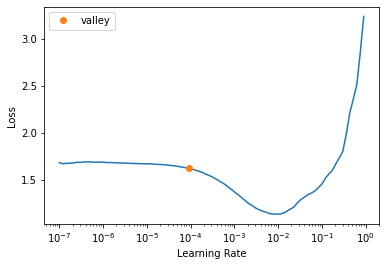

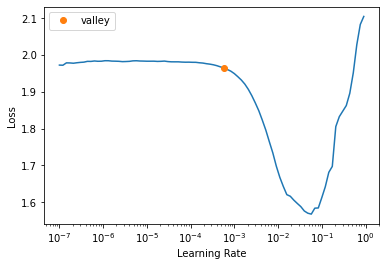

In [23]:
@patch_to(main_train)
def fit(learn,fit_type,epochs,freeze_epochs,initial_weights,pretrain):
    """We can patch in a modification, e.g. if we want subtype of fine_tune:supervised_pretrain to be different
    to fine_tune:bt_pretrain"""

    if fit_type == 'encoder_fine_tune': #i.e. barlow twins
        assert False

        #learn.encoder_fine_tune(epochs,freeze_epochs=freeze_epochs)
        lr_max=0.0030199517495930195
        print(f'lr_max={lr_max}')
        learn.fit_one_cycle(epochs,lr_max= lr_max)

    elif fit_type == 'fine_tune':

        if pretrain == False:
            assert False
            print('pretrain was False, and about to fit_one_cycle')
            learn.fit_one_cycle(epochs,lr_max=0.00027542) 

        elif pretrain == True:
            print('First freeze backbone and fit head for few epochs')
            
            learn.freeze()
            print('froze resnet')
            base_lr=2e-3
            learn.fit_one_cycle(freeze_epochs, slice(base_lr), pct_start=0.99)
            learn.unfreeze()
            print('unfroze resnet')


            lrs = learn.lr_find()
            lr_max = lrs.valley
            print(f'With initial_weights={initial_weights}, lrs.valley={lr_max}')
            learn.fit_one_cycle(epochs,lr_max=lr_max)


            #learn.linear_fine_tune(epochs,freeze_epochs=freeze_epochs) #This gave very similar performance, when pretrain=False (see above)

        #learn.no_freeze_linear_fine_tune(epochs,freeze_epochs=freeze_epochs) 

    else: raise Exception('Fit policy not of expected form')


@patch
def fine_tune(self:main_train):
    "fine tune in supervised fashion, according to tune_fit_policy, and get metrics"


    #encoder = pickle.loads(pickle.dumps(self.encoder)) #We might want to pretrain once and fine tune several times (varying e.g. tune augs)

    try: 
        encoder = self.encoder
    
    except AttributeError:
        _,self.encoder = create_model(which_model=self.initial_weights,ps=self.ps,device=self.device)

    model = LM(self.encoder)
    learn = Learner(self.dls_tune,model,splitter=my_splitter,cbs = [LinearBt(aug_pipelines=self.aug_pipelines_tune,n_in=self.n_in)],wd=0.0)

    #debugging
    #learn = Learner(self.dls_tune,model,cbs = [LinearBt(aug_pipelines=self.aug_pipelines_tune,n_in=self.n_in)],wd=0.0)

    main_train.fit(learn,fit_type='fine_tune',
                    epochs=self.numfit,freeze_epochs=self.freeze_numfit,
                    initial_weights=self.initial_weights,
                    pretrain=self.pretrain
                    ) #fine tuning (don't confuse this with fit policy!)
    scores,preds, acc = predict_model(self.xval,self.yval,model=model,aug_pipelines_test=self.aug_pipelines_test,numavg=3)
    #metrics dict will have f1 score, auc etc etc
    metrics = classification_report_wrapper(preds, self.yval, self.vocab, print_report=self.print_report)
    auc_dict = plot_roc(self.yval,preds,self.vocab,print_plot=self.print_plot)
    metrics['acc'],metrics['auc_dict'],metrics['scores'],metrics['preds'],metrics['xval'],metrics['yval'] = acc,auc_dict,scores,preds,self.xval,self.yval

    return metrics #


if __name__ == '__main__':

    freeze_dict = {'supervised_pretrain':10,'bt_pretrain':10}

    for initial_weights in ['supervised_pretrain','bt_pretrain']:

        main = main_train(dls_train=dls_train,dls_tune=dls_tune,dls_valid=dls_valid, xval=xval, yval=yval,
            aug_pipelines=aug_pipelines, aug_pipelines_tune=aug_pipelines_tune, aug_pipelines_test=aug_pipelines_test, 
            initial_weights=initial_weights,pretrain=True,
            num_epochs='na',numfit=50,freeze_num_epochs='na',freeze_numfit=freeze_dict[initial_weights],
            print_report=True,
                    )
        
        metrics = main.fine_tune()



# Ok, we can discard this methodology: doesn't improve

#Experiment: `fine_tune` with no freezing (i.e. no splitter): idea is that this should be ~~ to `linear_fine_tune` with freeze_epochs=1...

In [26]:
@patch_to(main_train)
def fit(learn,fit_type,epochs,freeze_epochs,initial_weights,pretrain):
    """We can patch in a modification, e.g. if we want subtype of fine_tune:supervised_pretrain to be different
    to fine_tune:bt_pretrain"""

    if fit_type == 'encoder_fine_tune': #i.e. barlow twins
        assert False

        #learn.encoder_fine_tune(epochs,freeze_epochs=freeze_epochs)
        lr_max=0.0030199517495930195
        print(f'lr_max={lr_max}')
        learn.fit_one_cycle(epochs,lr_max= lr_max)

    elif fit_type == 'fine_tune':

        if pretrain == False:
            assert False
            print('pretrain was False, and about to fit_one_cycle')
            learn.fit_one_cycle(epochs,lr_max=0.00027542) 

        elif pretrain == True:

            learn.fine_tune(epochs)
        


            #learn.linear_fine_tune(epochs,freeze_epochs=freeze_epochs) #This gave very similar performance, when pretrain=False (see above)

        #learn.no_freeze_linear_fine_tune(epochs,freeze_epochs=freeze_epochs) 

    else: raise Exception('Fit policy not of expected form')


@patch
def fine_tune(self:main_train):
    "fine tune in supervised fashion, according to tune_fit_policy, and get metrics"


    #encoder = pickle.loads(pickle.dumps(self.encoder)) #We might want to pretrain once and fine tune several times (varying e.g. tune augs)

    try: 
        encoder = self.encoder
    
    except AttributeError:
        _,self.encoder = create_model(which_model=self.initial_weights,ps=self.ps,device=self.device)

    model = LM(self.encoder)
    learn = Learner(self.dls_tune,model,cbs = [LinearBt(aug_pipelines=self.aug_pipelines_tune,n_in=self.n_in)],wd=0.0)

    #debugging
    #learn = Learner(self.dls_tune,model,cbs = [LinearBt(aug_pipelines=self.aug_pipelines_tune,n_in=self.n_in)],wd=0.0)

    main_train.fit(learn,fit_type='fine_tune',
                    epochs=self.numfit,freeze_epochs=self.freeze_numfit,
                    initial_weights=self.initial_weights,
                    pretrain=self.pretrain
                    ) #fine tuning (don't confuse this with fit policy!)
    scores,preds, acc = predict_model(self.xval,self.yval,model=model,aug_pipelines_test=self.aug_pipelines_test,numavg=3)
    #metrics dict will have f1 score, auc etc etc
    metrics = classification_report_wrapper(preds, self.yval, self.vocab, print_report=self.print_report)
    auc_dict = plot_roc(self.yval,preds,self.vocab,print_plot=self.print_plot)
    metrics['acc'],metrics['auc_dict'],metrics['scores'],metrics['preds'],metrics['xval'],metrics['yval'] = acc,auc_dict,scores,preds,self.xval,self.yval

    return metrics 


if __name__ == '__main__':

    from statistics import mean
    freeze_dict = {'supervised_pretrain':1,'bt_pretrain':1}
    acc_dict = {'supervised_pretrain':[],'bt_pretrain':[]}
    for _ in range(3):

        for initial_weights in ['supervised_pretrain','bt_pretrain']:

            main = main_train(dls_train=dls_train,dls_tune=dls_tune,dls_valid=dls_valid, xval=xval, yval=yval,
                aug_pipelines=aug_pipelines, aug_pipelines_tune=aug_pipelines_tune, aug_pipelines_test=aug_pipelines_test, 
                initial_weights=initial_weights,pretrain=True,
                num_epochs='na',numfit=50,freeze_num_epochs='na',freeze_numfit=freeze_dict[initial_weights],
                print_report=True,
                        )
            
            metrics = main.fine_tune()

            acc_dict[initial_weights].append(metrics['acc'])

    
    print(acc_dict)
    print(f"mean of 'supervised_pretrain' is: {mean(acc_dict['supervised_pretrain'])}")
    print(f"mean of 'bt_pretrain' is: {mean(acc_dict['bt_pretrain'])}")

    print('This is with freeze_epochs=1')
    print('')


epoch,train_loss,valid_loss,time
0,2.198840,None,00:07


/usr/local/lib/python3.8/dist-packages/fastprogress/fastprogress.py:73: UserWarning: Your generator is empty.
  warn("Your generator is empty.")


epoch,train_loss,valid_loss,time
0,1.976743,None,00:07
1,1.919162,None,00:06
2,1.831364,None,00:06
3,1.741897,None,00:07
4,1.651154,None,00:07
5,1.565352,None,00:07
6,1.455944,None,00:06
7,1.354369,None,00:06
8,1.246814,None,00:06
9,1.152457,None,00:06


                            precision    recall  f1-score   support

         actinic keratosis       0.48      0.65      0.55        20
      basal cell carcinoma       0.67      0.50      0.57        20
            dermatofibroma       0.81      0.89      0.85        19
                  melanoma       0.46      0.30      0.36        20
                     nevus       0.61      0.70      0.65        20
pigmented benign keratosis       0.61      0.55      0.58        20
      seborrheic keratosis       0.47      0.53      0.50        15
   squamous cell carcinoma       0.47      0.40      0.43        20
           vascular lesion       0.87      1.00      0.93        20

                  accuracy                           0.61       174
                 macro avg       0.61      0.61      0.60       174
              weighted avg       0.61      0.61      0.61       174



Using cache found in /root/.cache/torch/hub/facebookresearch_barlowtwins_main
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


epoch,train_loss,valid_loss,time
0,2.201106,None,00:06


/usr/local/lib/python3.8/dist-packages/fastprogress/fastprogress.py:73: UserWarning: Your generator is empty.
  warn("Your generator is empty.")


epoch,train_loss,valid_loss,time
0,2.180610,None,00:07
1,2.176012,None,00:06
2,2.173641,None,00:06
3,2.169192,None,00:07
4,2.164591,None,00:07
5,2.157824,None,00:07
6,2.150682,None,00:07
7,2.142295,None,00:07
8,2.132746,None,00:07
9,2.120432,None,00:06


                            precision    recall  f1-score   support

         actinic keratosis       0.64      0.70      0.67        20
      basal cell carcinoma       0.80      0.60      0.69        20
            dermatofibroma       0.81      0.89      0.85        19
                  melanoma       0.44      0.35      0.39        20
                     nevus       0.52      0.55      0.54        20
pigmented benign keratosis       0.50      0.60      0.55        20
      seborrheic keratosis       0.50      0.47      0.48        15
   squamous cell carcinoma       0.75      0.60      0.67        20
           vascular lesion       0.80      1.00      0.89        20

                  accuracy                           0.64       174
                 macro avg       0.64      0.64      0.63       174
              weighted avg       0.64      0.64      0.64       174



epoch,train_loss,valid_loss,time
0,2.209581,None,00:07


/usr/local/lib/python3.8/dist-packages/fastprogress/fastprogress.py:73: UserWarning: Your generator is empty.
  warn("Your generator is empty.")


epoch,train_loss,valid_loss,time
0,2.019029,None,00:07
1,1.947177,None,00:07
2,1.860526,None,00:07
3,1.779181,None,00:07
4,1.688436,None,00:07
5,1.588745,None,00:06
6,1.486588,None,00:06
7,1.383405,None,00:07
8,1.284180,None,00:07
9,1.185933,None,00:08


                            precision    recall  f1-score   support

         actinic keratosis       0.40      0.60      0.48        20
      basal cell carcinoma       0.76      0.65      0.70        20
            dermatofibroma       0.81      0.89      0.85        19
                  melanoma       0.40      0.30      0.34        20
                     nevus       0.58      0.55      0.56        20
pigmented benign keratosis       0.61      0.55      0.58        20
      seborrheic keratosis       0.44      0.47      0.45        15
   squamous cell carcinoma       0.60      0.45      0.51        20
           vascular lesion       0.87      1.00      0.93        20

                  accuracy                           0.61       174
                 macro avg       0.61      0.61      0.60       174
              weighted avg       0.61      0.61      0.60       174



Using cache found in /root/.cache/torch/hub/facebookresearch_barlowtwins_main
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


epoch,train_loss,valid_loss,time
0,2.195671,None,00:07


/usr/local/lib/python3.8/dist-packages/fastprogress/fastprogress.py:73: UserWarning: Your generator is empty.
  warn("Your generator is empty.")


epoch,train_loss,valid_loss,time
0,2.175599,None,00:07
1,2.171343,None,00:07
2,2.166853,None,00:07
3,2.161750,None,00:07
4,2.156812,None,00:07
5,2.149936,None,00:07
6,2.141233,None,00:08
7,2.132971,None,00:07
8,2.121602,None,00:07
9,2.108166,None,00:07


                            precision    recall  f1-score   support

         actinic keratosis       0.58      0.70      0.64        20
      basal cell carcinoma       0.60      0.75      0.67        20
            dermatofibroma       0.87      0.68      0.76        19
                  melanoma       0.50      0.40      0.44        20
                     nevus       0.60      0.60      0.60        20
pigmented benign keratosis       0.58      0.55      0.56        20
      seborrheic keratosis       0.50      0.53      0.52        15
   squamous cell carcinoma       0.67      0.60      0.63        20
           vascular lesion       0.90      0.95      0.93        20

                  accuracy                           0.64       174
                 macro avg       0.64      0.64      0.64       174
              weighted avg       0.65      0.64      0.64       174



epoch,train_loss,valid_loss,time
0,2.190292,None,00:07


/usr/local/lib/python3.8/dist-packages/fastprogress/fastprogress.py:73: UserWarning: Your generator is empty.
  warn("Your generator is empty.")


epoch,train_loss,valid_loss,time
0,1.994955,None,00:07
1,1.920805,None,00:06
2,1.845288,None,00:07
3,1.776659,None,00:07
4,1.691519,None,00:07
5,1.597924,None,00:07
6,1.503714,None,00:07
7,1.396016,None,00:07
8,1.293722,None,00:06
9,1.194009,None,00:07


                            precision    recall  f1-score   support

         actinic keratosis       0.46      0.60      0.52        20
      basal cell carcinoma       0.67      0.60      0.63        20
            dermatofibroma       0.65      0.89      0.76        19
                  melanoma       0.50      0.35      0.41        20
                     nevus       0.65      0.65      0.65        20
pigmented benign keratosis       0.55      0.60      0.57        20
      seborrheic keratosis       0.57      0.53      0.55        15
   squamous cell carcinoma       0.69      0.45      0.55        20
           vascular lesion       0.90      0.95      0.93        20

                  accuracy                           0.63       174
                 macro avg       0.63      0.63      0.62       174
              weighted avg       0.63      0.63      0.62       174



Using cache found in /root/.cache/torch/hub/facebookresearch_barlowtwins_main
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


epoch,train_loss,valid_loss,time
0,2.194742,None,00:07


/usr/local/lib/python3.8/dist-packages/fastprogress/fastprogress.py:73: UserWarning: Your generator is empty.
  warn("Your generator is empty.")


epoch,train_loss,valid_loss,time
0,2.176404,None,00:07
1,2.171415,None,00:07
2,2.168016,None,00:07
3,2.161770,None,00:07
4,2.156081,None,00:07
5,2.149856,None,00:07
6,2.142617,None,00:07
7,2.133732,None,00:07
8,2.123199,None,00:07
9,2.110856,None,00:07


                            precision    recall  f1-score   support

         actinic keratosis       0.64      0.70      0.67        20
      basal cell carcinoma       0.71      0.50      0.59        20
            dermatofibroma       0.73      0.84      0.78        19
                  melanoma       0.47      0.45      0.46        20
                     nevus       0.55      0.60      0.57        20
pigmented benign keratosis       0.61      0.70      0.65        20
      seborrheic keratosis       0.42      0.33      0.37        15
   squamous cell carcinoma       0.67      0.50      0.57        20
           vascular lesion       0.80      1.00      0.89        20

                  accuracy                           0.63       174
                 macro avg       0.62      0.63      0.62       174
              weighted avg       0.63      0.63      0.62       174

{'supervised_pretrain': [0.6149425506591797, 0.6091954112052917, 0.6264367699623108], 'bt_pretrain': [0.643678188

## Ok, our goal above is once and for all to get the best fit policies for each set of initial weights. Basically either `linear_fine_tune` or `fit_one_cycle`.

We need to double check that performance of `linear_fine_tune` is  > ~ to the old scheme of using `fine_tune` but not freezing the head (i.e. the error...). In fact, if we set freeze_epochs=1 it should be basically exactly the same.

So, we need to run the following final experiments:

- Verify that `linear_fine_tune` has mean performance as `fine_tune`, when freeze_epochs=1.
- Modulo this, check whether freezing for 1,3,6 epochs (supervised weights) or (1,3,6) epochs (BT weights) or something very close to that is best. This can be done quickly (e.g. one run per kind of initial weight...).
- Depending on results of `fit_one_cycle` above, can do more of that or leave it...


In [20]:
bt_model,encoder = create_model(which_model='bt_pretrain',ps=8192,device=device)
model = LM(encoder)

learn = Learner(dls_tune,model,splitter=my_splitter,cbs = [LinearBt(aug_pipelines=aug_pipelines_tune,n_in=3)],wd=0.0)


Using cache found in /root/.cache/torch/hub/facebookresearch_barlowtwins_main
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [17]:
@patch_to(main_train)
def fit(learn,fit_type,epochs,freeze_epochs,initial_weights,pretrain):
    """We can patch in a modification, e.g. if we want subtype of fine_tune:supervised_pretrain to be different
    to fine_tune:bt_pretrain"""

    if fit_type == 'encoder_fine_tune': #i.e. barlow twins
        assert False

        #learn.encoder_fine_tune(epochs,freeze_epochs=freeze_epochs)
        lr_max=0.0030199517495930195
        print(f'lr_max={lr_max}')
        learn.fit_one_cycle(epochs,lr_max= lr_max)

    elif fit_type == 'fine_tune':

        if pretrain == False:
            assert False
            print('pretrain was False, and about to fit_one_cycle')
            learn.fit_one_cycle(epochs,lr_max=0.00027542) 

        elif pretrain == True:

            learn.fine_tune(epochs,freeze_epochs=freeze_epochs)
        


            #learn.linear_fine_tune(epochs,freeze_epochs=freeze_epochs) #This gave very similar performance, when pretrain=False (see above)

        #learn.no_freeze_linear_fine_tune(epochs,freeze_epochs=freeze_epochs) 

    else: raise Exception('Fit policy not of expected form')


@patch
def fine_tune(self:main_train):
    "fine tune in supervised fashion, according to tune_fit_policy, and get metrics"


    #encoder = pickle.loads(pickle.dumps(self.encoder)) #We might want to pretrain once and fine tune several times (varying e.g. tune augs)

    try: 
        encoder = self.encoder
    
    except AttributeError:
        _,self.encoder = create_model(which_model=self.initial_weights,ps=self.ps,device=self.device)

    model = LM(self.encoder)
    learn = Learner(self.dls_tune,model,splitter=my_splitter,cbs = [LinearBt(aug_pipelines=self.aug_pipelines_tune,n_in=self.n_in)],wd=0.0)

    #debugging
    #learn = Learner(self.dls_tune,model,cbs = [LinearBt(aug_pipelines=self.aug_pipelines_tune,n_in=self.n_in)],wd=0.0)

    main_train.fit(learn,fit_type='fine_tune',
                    epochs=self.numfit,freeze_epochs=self.freeze_numfit,
                    initial_weights=self.initial_weights,
                    pretrain=self.pretrain
                    ) #fine tuning (don't confuse this with fit policy!)
    scores,preds, acc = predict_model(self.xval,self.yval,model=model,aug_pipelines_test=self.aug_pipelines_test,numavg=3)
    #metrics dict will have f1 score, auc etc etc
    metrics = classification_report_wrapper(preds, self.yval, self.vocab, print_report=self.print_report)
    auc_dict = plot_roc(self.yval,preds,self.vocab,print_plot=self.print_plot)
    metrics['acc'],metrics['auc_dict'],metrics['scores'],metrics['preds'],metrics['xval'],metrics['yval'] = acc,auc_dict,scores,preds,self.xval,self.yval

    return metrics #


if __name__ == '__main__':

    freeze_dict = {'supervised_pretrain':3,'bt_pretrain':6}

    for initial_weights in ['supervised_pretrain','bt_pretrain']:

        main = main_train(dls_train=dls_train,dls_tune=dls_tune,dls_valid=dls_valid, xval=xval, yval=yval,
            aug_pipelines=aug_pipelines, aug_pipelines_tune=aug_pipelines_tune, aug_pipelines_test=aug_pipelines_test, 
            initial_weights=initial_weights,pretrain=True,
            num_epochs='na',numfit=50,freeze_num_epochs='na',freeze_numfit=freeze_dict[initial_weights],
            print_report=True,
                    )
        
        metrics = main.fine_tune()
        print(initial_weights)



epoch,train_loss,valid_loss,time
0,2.209600,None,00:06
1,2.198855,None,00:06
2,2.167002,None,00:06


/usr/local/lib/python3.8/dist-packages/fastprogress/fastprogress.py:73: UserWarning: Your generator is empty.
  warn("Your generator is empty.")


epoch,train_loss,valid_loss,time
0,2.033681,None,00:07
1,2.027433,None,00:07
2,2.019403,None,00:06
3,2.009222,None,00:06
4,1.995062,None,00:06
5,1.978695,None,00:06
6,1.964653,None,00:06
7,1.951717,None,00:07
8,1.936757,None,00:06
9,1.915698,None,00:06


                            precision    recall  f1-score   support

         actinic keratosis       0.41      0.60      0.49        20
      basal cell carcinoma       0.50      0.55      0.52        20
            dermatofibroma       0.67      0.74      0.70        19
                  melanoma       0.36      0.25      0.29        20
                     nevus       0.54      0.65      0.59        20
pigmented benign keratosis       0.44      0.35      0.39        20
      seborrheic keratosis       0.25      0.27      0.26        15
   squamous cell carcinoma       0.40      0.20      0.27        20
           vascular lesion       0.86      0.95      0.90        20

                  accuracy                           0.51       174
                 macro avg       0.49      0.51      0.49       174
              weighted avg       0.50      0.51      0.50       174

supervised_pretrain


Using cache found in /root/.cache/torch/hub/facebookresearch_barlowtwins_main
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


epoch,train_loss,valid_loss,time
0,2.204304,None,00:06
1,2.200935,None,00:06
2,2.195050,None,00:06
3,2.188551,None,00:06
4,2.178891,None,00:06
5,2.165984,None,00:06


/usr/local/lib/python3.8/dist-packages/fastprogress/fastprogress.py:73: UserWarning: Your generator is empty.
  warn("Your generator is empty.")


epoch,train_loss,valid_loss,time
0,2.067895,None,00:06
1,2.070020,None,00:06
2,2.068383,None,00:07
3,2.066738,None,00:06
4,2.063234,None,00:06
5,2.059021,None,00:06
6,2.055268,None,00:06
7,2.051841,None,00:06
8,2.046194,None,00:06
9,2.040144,None,00:06


                            precision    recall  f1-score   support

         actinic keratosis       0.36      0.60      0.45        20
      basal cell carcinoma       0.32      0.30      0.31        20
            dermatofibroma       0.55      0.58      0.56        19
                  melanoma       0.42      0.25      0.31        20
                     nevus       0.44      0.55      0.49        20
pigmented benign keratosis       0.29      0.20      0.24        20
      seborrheic keratosis       1.00      0.07      0.12        15
   squamous cell carcinoma       0.41      0.55      0.47        20
           vascular lesion       0.61      0.70      0.65        20

                  accuracy                           0.43       174
                 macro avg       0.49      0.42      0.40       174
              weighted avg       0.47      0.43      0.41       174

bt_pretrain


#Ok, so something is wrong.

## Now we edit `main_train` to add a path to save the model. Also put numavg up to 10 in predict_model: more stability, 

In [ ]:
@patch
def fit_one_cycle(self:Learner, n_epoch, lr_max=None, div=25., div_final=1e5, pct_start=0.25, wd=None,
                  moms=None, cbs=None, reset_opt=False, start_epoch=0):
    "Fit `self.model` for `n_epoch` using the 1cycle policy."
    print('inside copy pasted fit_one_cycle')
    if self.opt is None: self.create_opt()
    self.opt.set_hyper('lr', self.lr if lr_max is None else lr_max)
    lr_max = np.array([h['lr'] for h in self.opt.hypers])
    scheds = {'lr': combined_cos(pct_start, lr_max/div, lr_max, lr_max/div_final),
              'mom': combined_cos(pct_start, *(self.moms if moms is None else moms))}
    self.fit(n_epoch, cbs=ParamScheduler(scheds)+L(cbs), reset_opt=reset_opt, wd=wd, start_epoch=start_epoch)

In [ ]:
@patch
@delegates(Learner.fit_one_cycle)
def linear_fine_tune(self:Learner, epochs, base_lr=2e-3, freeze_epochs=1, lr_mult=100,
              pct_start=0.3, div=5.0, **kwargs):
    "Extremely minor change to fine_tune, but seems to work better"
    print('inside copy pasted linear_fine_tune')

    self.freeze()
    self.fit_one_cycle(freeze_epochs, slice(base_lr), pct_start=0.99, **kwargs)
    base_lr /= 2
    self.unfreeze()
    #self.fit_one_cycle(epochs, slice(base_lr/lr_mult, base_lr), pct_start=pct_start, div=div, **kwargs)
    self.fit_one_cycle(epochs, slice(base_lr, base_lr), pct_start=pct_start, div=div, **kwargs)

In [ ]:
#| export

class main_train:
    """Instantiate and (optionally) train the encoder. Then fine-tune the supervised model. 
    Outputs metrics on validation data"""

    def __init__(self,
                 dls_train, #used for training BT (if pretrain=True)
                 dls_tune , #used for tuning
                 dls_valid, #used to compute metrics / evaluate results. 
                 xval, #currently `predict_model` below assumes this is entire validation / test data
                 yval,
                 aug_pipelines, #the aug pipeline for self-supervised learning
                 aug_pipelines_tune, #the aug pipeline for supervised learning
                 aug_pipelines_test, #test (or valid) time augmentations 
                 initial_weights, #Which initial weights to use
                 pretrain, #Whether to fit BT
                 num_epochs, #number of BT fit epochs
                 numfit, #number of tune_fit epochs
                 freeze_num_epochs, #How many epochs to freeze body for when training BT
                 freeze_numfit, #How many epochs to freeze body for when fine tuning
                 ps=8192, #projection size
                 n_in=3, #color channels
                 indim=2048, #dimension output of encoder (2048 for resnet50)
                 outdim=9, #number of classes
                 print_report=False, #F1 metrics etc
                 print_plot=False, #ROC curve
                 tune_model_path=None,
                 ):
        store_attr()
        self.vocab = self.dls_valid.vocab
        self.device = 'cuda' if torch.cuda.is_available else 'cpu'

                
                 

                 #Soon we might want to save some models here:

                 #if self.model_type == 'res_proj': test_eq(self.fit_policy,'resnet_fine_tune') #I THINK this is only viable option?
                 #self.encoder_path = f'/content/drive/My Drive/models/baselineencoder_initial_weights={self.initial_weights}_pretrain={self.pretrain}.pth'
                 #self.tuned_model_path = f'/content/drive/My Drive/models/baselinefinetuned_initial_weights={self.initial_weights}_pretrain={self.pretrain}.pth'

    @staticmethod
    def fit(learn,fit_type,epochs,freeze_epochs,initial_weights):
        """We can patch in a modification, e.g. if we want subtype of fine_tune:supervised_pretrain to be different
        to fine_tune:bt_pretrain"""

        if fit_type == 'encoder_fine_tune': #i.e. barlow twins

            learn.encoder_fine_tune(epochs,freeze_epochs=freeze_epochs) 

        elif fit_type == 'fine_tune':
            
            #elif initial_weights == 'supervised_pretrain':
            learn.linear_fine_tune(epochs,freeze_epochs=freeze_epochs) 
            #learn.fine_tune(epochs,freeze_epochs=freeze_epochs)

        else: raise Exception('Fit policy not of expected form')

    def train_encoder(self):
        "create encoder and (optionally, if pretrain=True) train with BT algorithm, according to fit_policy"

        try: #get existing encoder and plonk on new projector
            encoder = self.encoder
            encoder.cpu()
            bt_model = create_barlow_twins_model(encoder, hidden_size=self.ps,projection_size=self.ps,nlayers=3)
            bt_model.cuda()

        except AttributeError: #otherwise, create
            bt_model,encoder = create_model(which_model=self.initial_weights,ps=self.ps,device=self.device)

        if self.pretrain: #train encoder according to fit policy

            learn = Learner(self.dls_train,bt_model,splitter=my_splitter_bt,cbs=[BarlowTwins(self.aug_pipelines,n_in=self.n_in,lmb=1/self.ps,print_augs=False)])
            main_train.fit(learn,fit_type='encoder_fine_tune',
                           epochs=self.num_epochs,freeze_epochs=self.freeze_num_epochs,
                           initial_weights=self.initial_weights
                          )
            
        self.encoder = bt_model.encoder

    def fine_tune(self):
        "fine tune in supervised fashion, according to tune_fit_policy, and get metrics"

        #encoder = pickle.loads(pickle.dumps(self.encoder)) #We might want to pretrain once and fine tune several times (varying e.g. tune augs)

        try: 
            encoder = self.encoder
        
        except AttributeError:
            _,self.encoder = create_model(which_model=self.initial_weights,ps=self.ps,device=self.device)

        model = LM(self.encoder)
        learn = Learner(self.dls_tune,model,splitter=my_splitter,cbs = [LinearBt(aug_pipelines=self.aug_pipelines_tune,n_in=self.n_in)],wd=0.0)

        #debugging
        #learn = Learner(self.dls_tune,model,cbs = [LinearBt(aug_pipelines=self.aug_pipelines_tune,n_in=self.n_in)],wd=0.0)

        main_train.fit(learn,fit_type='fine_tune',
                       epochs=self.numfit,freeze_epochs=self.freeze_numfit,
                       initial_weights=self.initial_weights
                      ) #fine tuning (don't confuse this with fit policy!)
        scores,preds, acc = predict_model(self.xval,self.yval,model=model,aug_pipelines_test=self.aug_pipelines_test,numavg=10)
        #metrics dict will have f1 score, auc etc etc
        metrics = classification_report_wrapper(preds, self.yval, self.vocab, print_report=self.print_report)
        auc_dict = plot_roc(self.yval,preds,self.vocab,print_plot=self.print_plot)
        metrics['acc'],metrics['auc_dict'],metrics['scores'],metrics['preds'],metrics['xval'],metrics['yval'] = acc,auc_dict,scores,preds,self.xval,self.yval
  

        if self.tune_model_path != None:
            metrics['classif_model_path'] = self.tune_model_path

            torch.save(model.state_dict(), self.tune_model_path)
        return metrics #

    def __call__(self):

        self.train_encoder() #train (or extract) the encoder
        metrics = self.fine_tune()
        
        return metrics


if __name__ == '__main__':

    print("What is going on with supervised initial weights?")

    main = main_train(dls_train=dls_train,dls_tune=dls_tune,dls_valid=dls_valid, xval=xval, yval=yval,
        aug_pipelines=aug_pipelines, aug_pipelines_tune=aug_pipelines_tune, aug_pipelines_test=aug_pipelines_test, 
        initial_weights='supervised_pretrain',pretrain=False,
        num_epochs='na',numfit=50,freeze_num_epochs='na',freeze_numfit=6,
        print_report=True,
        tune_model_path = None# f'/content/drive/My Drive/models/initial_weights={initial_weights}_pretrain={pretrain}_{num}.pth'
                )

    metrics = main.fine_tune()

    print('Just copy pasted patches above in...')





In [ ]:
predict_model??

In [ ]:
scores = metrics['scores']

predict_model(scores=scores,yval=yval)

## Ok, it seems we needed to set freeze_numfit to a higher range for supervised weights as well...

In [ ]:
initial_weights

## Experiment: explain...

In [ ]:
def run_main_train(pretrain=True,initial_weights='bt_pretrain',num_epochs='na',freeze_num_epochs='na',numfit=50,num=5):
    "run main_train num times."

    if initial_weights == 'bt_pretrain':
        freeze_numfit=6
    elif initial_weights == 'supervised_pretrain':
        freeze_numfit=6
    
    main_dict = {}
    for i in range(num):

        main = main_train(dls_train=dls_train,dls_tune=dls_tune,dls_valid=dls_valid, xval=xval, yval=yval,
                aug_pipelines=aug_pipelines, aug_pipelines_tune=aug_pipelines_tune, aug_pipelines_test=aug_pipelines_test, 
                initial_weights=initial_weights,pretrain=pretrain,
                num_epochs=num_epochs,numfit=numfit,freeze_num_epochs=freeze_num_epochs,freeze_numfit=freeze_numfit,
                print_report=True,
                tune_model_path = f'/content/drive/My Drive/models/initial_weights={initial_weights}_pretrain={pretrain}_{num}.pth'
                        )
        
        metrics = main.fine_tune()
        main_dict[i] = metrics

    return main_dict
        

In [ ]:
#lst = ['bt_pretrain','supervised_pretrain']
#results={'bt_pretrain':None,'supervised_pretrain':None} 

lst = ['supervised_pretrain']

for initial_weights in lst:
    main_dict = run_main_train(initial_weights,initial_weights=initial_weights,num_epochs='na',freeze_num_epochs='na',numfit=50,num=5)

    results[initial_weights] = main_dict #main_dict has result of running main num=3 times.

save_dict_to_gdrive(results,'nonrandom_weights_baseline') 

How to load:

In [ ]:
#results = load_dict_from_gdrive('nonrandom_weights_baseline') 

How to load a model:

In [ ]:
# #Get path
# path = results['bt_pretrain'][0]['classif_model_path']

# #init model
# _,encoder = create_model(which_model='bt_pretrain',ps=8192,device=device)
# model = LM(encoder)

# model.load_state_dict(torch.load(path, map_location='cuda:0'))





#Print out result of each run and save: 

In [ ]:
from statistics import mean,stdev
print('pretrained initial weights: ')
for initial_weights in lst:

    _results = [results[initial_weights][i]['acc'] for i in range(len(results[initial_weights]))]

    print(f"\n initial_weights={initial_weights}, results are: {_results}")
    print(f"mean is: {mean(_results)}\n")
    #print(f"std is: {stdev(_results)}")


## Ok, the bt initial weights make sense; but what has happened to supervised_pretrain? These were doing so much better before?

In [ ]:
#save_dict_to_gdrive(results,'base_results')

In [ ]:
from itertools import combinations

print('Ensembling within type of initial weights')

def within_ensemble_results(results,key,param='pretrain'):

    print(f'Results for {param}={key}')

    _results = list(results[key].values())
    _results = list(combinations(_results,2)) #all pairs of results. So for num=3, will be 3
    for v in _results:

        print(f"\nAcc of first guy in ensemble is: {v[0]['acc']}")
        print(f"Acc of second guy in ensemble is: {v[1]['acc']}")
        _,acc = predict_ensemble(yval=yval,scores1=v[0]['scores'],scores2=v[1]['scores'])
        print(f'Acc of ensemble is:{acc}\n')

In [ ]:
within_ensemble_results(results,key=True)

In [ ]:
#within_ensemble_results(results,key=False)

In [ ]:
import itertools
print('Ensembling between')

def between_ensemble_results(results,key1,key2,param='pretrain'):

    _results = list(itertools.product(results[key1].values(),results[key2].values()))

    for v in _results:

        print(f"\nAcc of first guy in ensemble ({key1}) is: {v[0]['acc']}")
        print(f"Acc of second guy in ensemble ({key2}) is: {v[1]['acc']}")
        _,acc = predict_ensemble(yval=yval,scores1=v[0]['scores'],scores2=v[1]['scores'])
        print(f'Acc of ensemble is:{acc}\n')


 

Between ensemble doesn't matter as much here: i.e. between is between pretrain=True and pretrain=False

In [ ]:
between_ensemble_results(results,key1=True,key2=False)

## Ok, plan of attack now:

- Ensembling between models: BT initial weights vs supervised initial weights, superior to ensembling within models. This is with pretrain=False

- Ensembling between models: random initial weights, and either pretrain=True (i.e. pretrain in BT way) or pretrain=False (standard supervised learning). Early experiments showed that pretraining yielded minor gains (53% vs 50% mean acc ?) however ensembling between models yielded large gains!

In other words, we have two kinds of ensemble setups.

- Implement ensemble decorrelation idea on this last guy.

In [ ]:
#| hide

# #old supervised baseline (with fine tune)

# tem = {0: 0.6724137663841248,
#  1: 0.7126436829566956,
#  2: 0.6724137663841248,
#  3: 0.6321839094161987,
#  4: 0.6896551847457886}

# from statistics import mean
# mean(list(tem.values()))